In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [3]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [4]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 5s 111ms/step - loss: 0.0219 - val_loss: 2.4067e-04
Epoch 2/100
21/21 [==============================] - 1s 43ms/step - loss: 0.0015 - val_loss: 2.4275e-04
Epoch 3/100
21/21 [==============================] - 1s 42ms/step - loss: 5.9277e-04 - val_loss: 2.2555e-04
Epoch 4/100
21/21 [==============================] - 1s 43ms/step - loss: 5.6918e-04 - val_loss: 2.0348e-04
Epoch 5/100
21/21 [==============================] - 1s 42ms/step - loss: 5.2339e-04 - val_loss: 2.0500e-04
Epoch 6/100
21/21 [==============================] - 1s 42ms/step - loss: 4.9229e-04 - val_loss: 1.9017e-04
Epoch 7/100
21/21 [==============================] - 1s 43ms/step - loss: 4.7214e-04 - val_loss: 1.9783e-04
Epoch 8/100
21/21 [==============================] - 1s 42ms/step - loss: 4.6023e-04 - val_loss: 2.0701e-04
Epoch 9/100
21/21 [==============================] - 1s 43ms/step - loss: 4.3916e-04 - val_loss: 2.0835e-04
Epoch 10/100
21/21 [===============

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 17ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [14]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 29783.004864688643


In [15]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9991551226034
Testing MAE: 29701.45527517243


In [16]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.2330123335123062], [0.2349100112915039], [0.23708531260490417], [0.23939307034015656], [0.24178345501422882], [0.24423302710056305], [0.24672968685626984], [0.2492666244506836], [0.25183963775634766], [0.2544459104537964], [0.25708329677581787], [0.2597501277923584], [0.2624451220035553], [0.2651672065258026], [0.26791539788246155], [0.2706889510154724], [0.27348706126213074], [0.27630922198295593], [0.27915486693382263], [0.28202348947525024], [0.28491467237472534], [0.2878279387950897], [0.29076293110847473], [0.2937192916870117], [0.29669660329818726], [0.2996945083141327], [0.3027125895023346], [0.30575063824653625], [0.30880802869796753], [0.3118846118450165], [0.31497979164123535], [0.31809335947036743], [0.32122477889060974], [0.32437360286712646], [0.32753944396972656], [0.33072197437286377], [0.33392050862312317], [0.3371347188949585], [0.3403639793395996], [0.34360793232917786], [0.3468659222126007], [0.35013753175735474], [0.35342204570770264], [0.3567189872264862], [0.3

In [17]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27936.87151016],
       [28110.70809336],
       [28309.97635264],
       [28521.3782692 ],
       [28740.34921823],
       [28964.74202424],
       [29193.4482915 ],
       [29425.84420614],
       [29661.54483271],
       [29900.29218253],
       [30141.88969282],
       [30386.18448141],
       [30633.05915662],
       [30882.41543708],
       [31134.16323148],
       [31388.23428888],
       [31644.55489821],
       [31903.07864883],
       [32163.75366999],
       [32426.53355103],
       [32691.38007142],
       [32958.24955053],
       [33227.1092279 ],
       [33497.92634306],
       [33770.66267547],
       [34045.28546467],
       [34321.7564901 ],
       [34600.05664151],
       [34880.12858807],
       [35161.9586796 ],
       [35445.49231532],
       [35730.71038495],
       [36017.5637478 ],
       [36306.01145328],
       [36596.0180109 ],
       [36887.55339023],
       [37180.55480037],
       [37474.9922109 ],
       [37770.80829101],
       [38067.97028022],


In [19]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [20]:
print(y_pred_with_test_data.shape)
test_data.shape

(160,)


(160, 1)

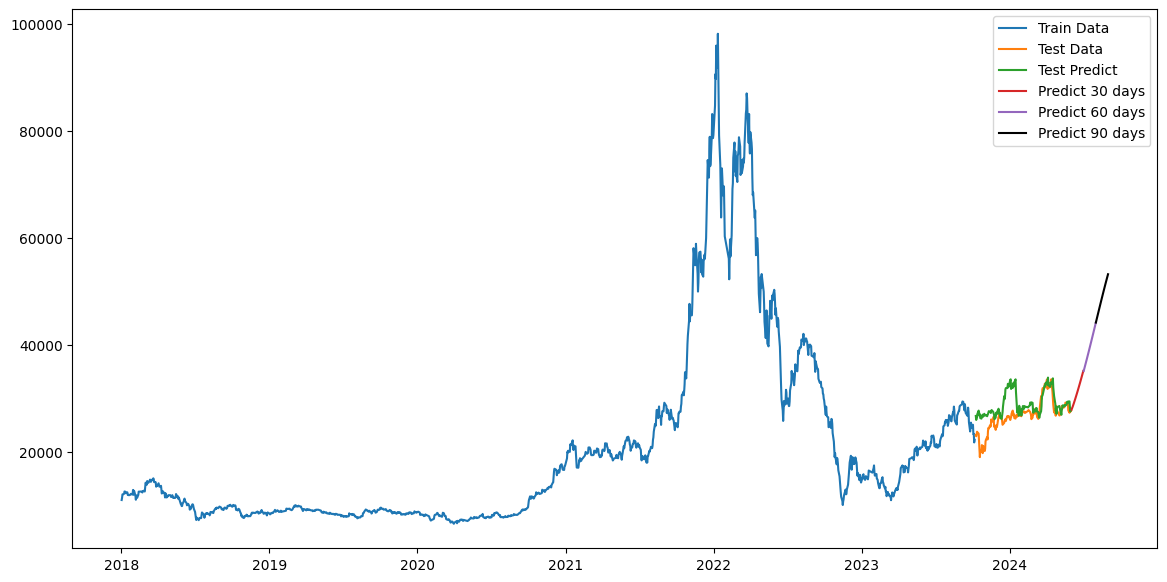

In [22]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()